In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

In [218]:
os.chdir("C:/Users/micha/OneDrive/Dokumenty/GitHub/Machine_Learning_Regression/Machine_Learning_Regression")

df = pd.read_csv('data/output/df_train.csv', index_col=0)
df_test = pd.read_csv('data/output/df_test.csv', index_col=0)


df.sample(10)

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
2151525,24.900000,2.0,137.0,1,62.00000,1.0,32.0,9,10.0,8,1.0,N,M,3657
154112,25.600000,0.0,141.0,4,59.00000,14.0,31.0,6,0.0,2,13.0,N,F,2955
1400942,21.600000,1.0,176.0,1,69.00000,30.0,46.0,4,0.0,3,26.0,N,F,2778
2102514,31.100000,2.0,211.0,1,59.00079,57.0,30.0,3,10.0,2,15.0,N,M,3925
533818,21.100000,1.0,169.0,1,67.00000,34.0,33.0,4,0.0,3,13.0,N,M,3317
282247,38.008218,2.0,348.0,3,68.00000,98.0,33.0,3,0.0,3,6.0,Y,F,3440
914619,27.500000,1.0,215.0,6,65.00000,50.0,32.0,8,0.0,2,6.0,N,F,2439
2196924,29.100000,2.0,178.0,1,61.00000,24.0,40.0,1,0.0,4,20.0,Y,F,3232
1235556,22.700000,1.0,130.0,1,61.00000,10.0,44.0,3,0.0,1,16.0,Y,M,3285
744868,26.000000,1.0,208.0,1,69.00000,32.0,23.0,4,0.0,1,8.0,N,M,2850


## Transforming variables

Delete maybe weight, use more of the weight gain, may be more important. USE BMI, we can factorise it
Need to hot encode:
* mother_marital_status
* mother_race
* father_education
* parental_care_month
* previous_cesarean
* newborn_gender

In [165]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=False, bins=50)
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.etr
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df['newborn_weight'])
    plt.plot()

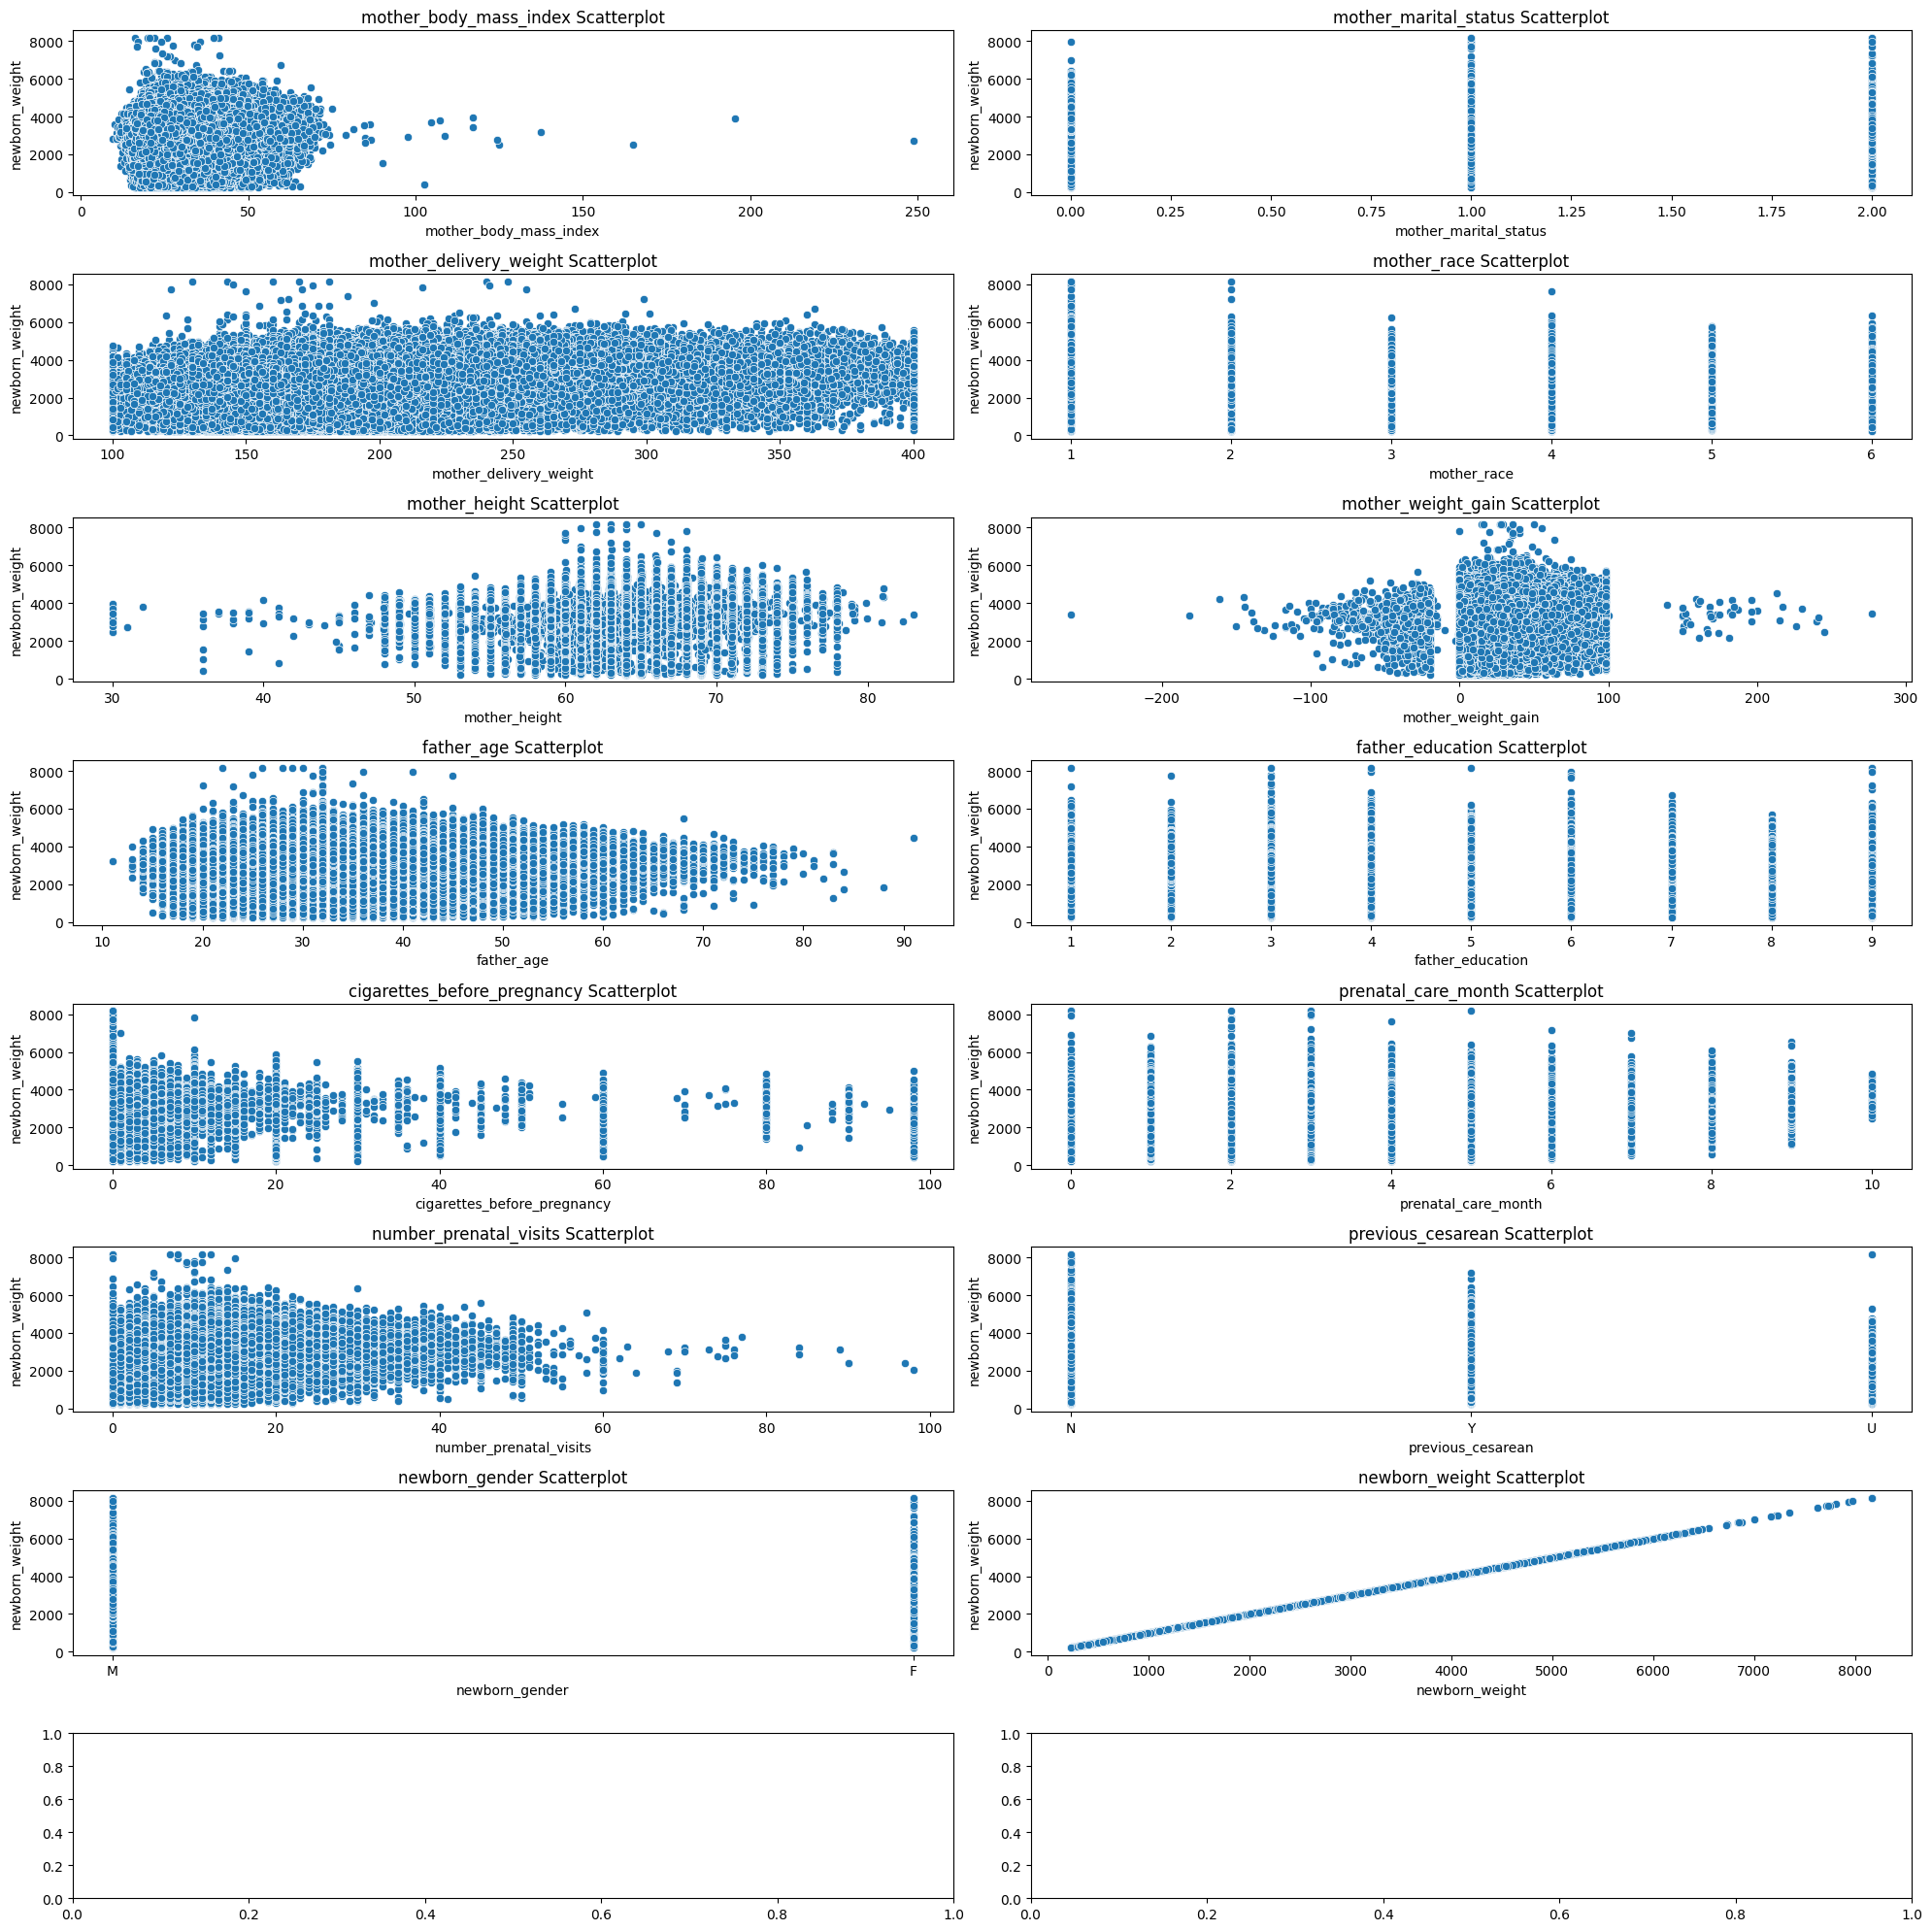

In [166]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

### Deleting outliers

Log Transformation & Deleting outliers

In [167]:
df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
df.loc[df['father_age'] > 80, 'father_age'] = 80
df.loc[df['mother_height'] < 45, 'mother_height'] = 45
df['mother_delivery_weight_log'] = np.log(df['mother_delivery_weight'])
df['mother_body_mass_index_log'] = np.log(df['mother_body_mass_index'])

### Hot encoding

In [168]:
def feature_engineering(df):

    df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
    df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
    df.loc[df['father_age'] > 80, 'father_age'] = 80
    df.loc[df['mother_height'] < 45, 'mother_height'] = 45
    df['mother_delivery_weight_log'] = np.log(df['mother_delivery_weight'])
    df['mother_body_mass_index_log'] = np.log(df['mother_body_mass_index'])

    df = pd.get_dummies(df, columns=['mother_marital_status'])
    df.rename(columns={'mother_marital_status_1': 'mother_marital_status_married', 
                    'mother_marital_status_2': 'mother_marital_status_not_married'}, inplace=True)

    race_mapping = {
        1: 'White',
        2: 'Black',
        3: 'AIAN',
        4: 'Asian',
        5: 'NHOPI',
        6: 'More than one race'
    }
    df = pd.get_dummies(df, columns=['mother_race'])
    df.rename(columns=race_mapping, inplace=True)

    education_mapping = {
        1: 'Primary education',
        2: 'Primary education',
        3: 'Medium education',
        4: 'Medium education',
        5: 'Medium education',
        6: 'Higher education',
        7: 'Higher education',
        8: 'Professional education',
        9: 'Professional education'
    }
    df['father_education'] = df['father_education'].map(education_mapping)
    df = pd.get_dummies(df, columns=['father_education'])

    df['prenatal_care_month'] = df['prenatal_care_month'].replace([1, 2, 3], 1)
    df['prenatal_care_month'] = df['prenatal_care_month'].replace([4, 5, 6], 2)
    df['prenatal_care_month'] = df['prenatal_care_month'].replace([7, 8, 9, 10], 3)
    encoded_columns = pd.get_dummies(df['prenatal_care_month'], prefix='prenatal_care')
    encoded_columns.columns = encoded_columns.columns.str.replace('prenatal_care_', 'prenatal_care_')
    df = pd.concat([df, encoded_columns], axis=1)

    df['previous_cesarean'] = df['previous_cesarean'].map({'Y': 1, 'N': 0, 'U': 0})

    df['newborn_gender'] = (df['newborn_gender'] == 'M').astype(int)

    df['smoker'] =(df['cigarettes_before_pregnancy'] > 0).astype(int)
    df = df.drop('prenatal_care_0', axis=1)

    return df



In [169]:
df_test = feature_engineering(df_test)
df = feature_engineering(df)

In [170]:
df_test.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy',
       'prenatal_care_month', 'number_prenatal_visits', 'previous_cesarean',
       'newborn_gender', 'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_0.0',
       'mother_marital_status_1.0', 'mother_marital_status_2.0',
       'mother_race_1', 'mother_race_2', 'mother_race_3', 'mother_race_4',
       'mother_race_5', 'mother_race_6', 'father_education_Higher education',
       'father_education_Medium education',
       'father_education_Primary education',
       'father_education_Professional education', 'prenatal_care_1',
       'prenatal_care_2', 'prenatal_care_3', 'smoker'],
      dtype='object')

In [171]:
df = df.reset_index(drop=True)


In [172]:
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]

percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)


,Missing Values,Percentage


In [173]:
#quick_viz(df['mother_body_mass_index'])

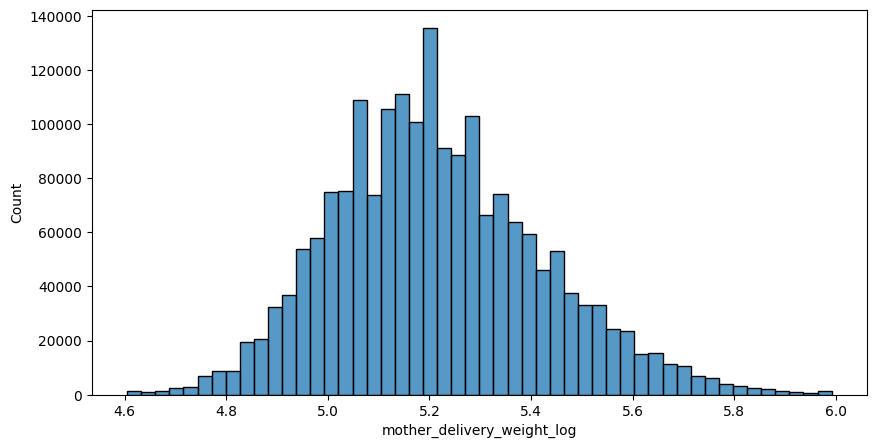

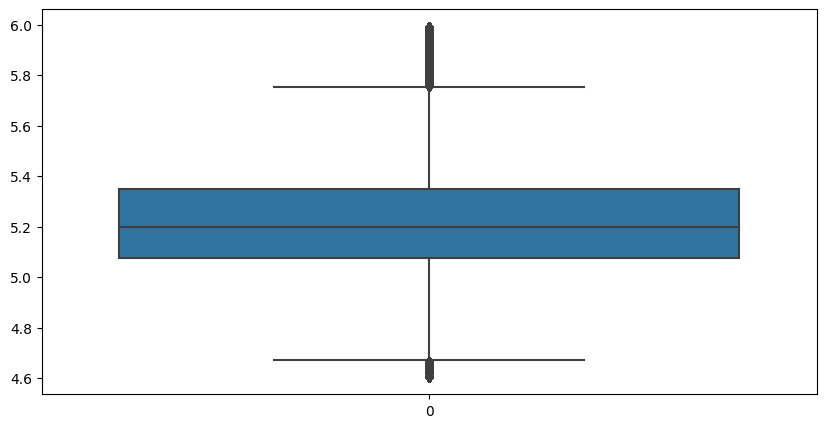

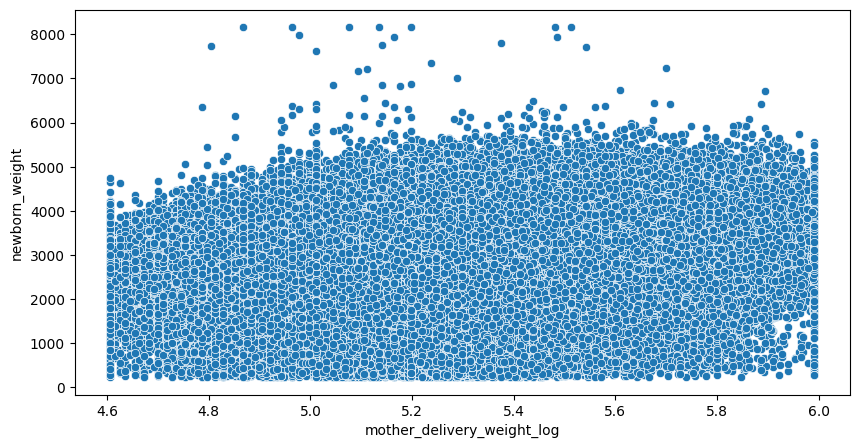

In [174]:
quick_viz(df['mother_delivery_weight_log'])

## Feature Selection

### Sampling the data

In [175]:
sample_1 = df.sample(500000, random_state=1)
sample_2 = df.sample(500000, random_state=2)
sample_3 = df.sample(500000, random_state=3)

In [176]:
y_col = ['newborn_weight']

In [184]:
x_col = ['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy',
       'prenatal_care_month', 'number_prenatal_visits', 'previous_cesarean',
       'newborn_gender', 'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_0.0',
       'mother_marital_status_1.0', 'mother_marital_status_2.0',
       'mother_race_1', 'mother_race_2', 'mother_race_3', 'mother_race_4',
       'mother_race_5', 'mother_race_6', 'father_education_Higher education',
       'father_education_Medium education',
       'father_education_Primary education',
       'father_education_Professional education', 'prenatal_care_1',
       'prenatal_care_2', 'prenatal_care_3', 'smoker']

In [185]:
sel = VarianceThreshold(0.01)
sel_var = sel.fit_transform(sample_1[x_col])
col_imp = sample_1[x_col][sample_1[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(sample_1[x_col].columns.tolist()) - set(col_imp)


In [186]:
col_redundant
general_ranking = pd.DataFrame(index=x_col)

In [187]:
scaler = StandardScaler()


sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=10))
sel_.fit(scaler.fit_transform(sample_1[x_col]), sample_1[y_col])
sel_.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x6', 'x7', 'x10', 'x11', 'x12', 'x14',
       'x16', 'x19', 'x20', 'x22', 'x24', 'x26', 'x27', 'x28'],
      dtype=object)

### Mutual information

In [188]:
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_regression(sample_1[[i]].values, sample_1[y_col].values.ravel())[0]})

In [189]:
miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["score"])

In [190]:
miDF.sort_values(by="score").head(10)

,score
mother_race_5,0.000000
mother_race_6,0.000000
father_education_Primary education,0.000000
mother_race_3,0.000435
prenatal_care_2,0.000913
previous_cesarean,0.001151
father_education_Professional education,0.001281
father_education_Medium education,0.001569
cigarettes_before_pregnancy,0.001570
prenatal_care_1,0.001822


In [191]:
miDF.sort_values(by="score", ascending=False).head(10)

,score
newborn_weight,1.409951
mother_delivery_weight,0.035626
mother_delivery_weight_log,0.034466
number_prenatal_visits,0.026552
mother_weight_gain,0.018225
mother_height,0.014862
mother_body_mass_index_log,0.012712
mother_body_mass_index,0.010185
mother_race_1,0.009967
mother_race_2,0.009407


In [192]:
general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)
general_ranking.rename(columns={"score": "mi_score"}, inplace=True)

### F-score

In [193]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
fscore = dict()
for i in x_col:
    fscore.update({i: f_regression(sample_1[[i]].values, sample_1[y_col].values.ravel())[1]})

In [194]:
fscoreDF = pd.DataFrame.from_dict(fscore, orient="index", columns=["p_value_score"])
fscoreDF.sort_values(by="p_value_score").head(10)

,p_value_score
mother_body_mass_index,0.0
prenatal_care_1,0.0
father_education_Professional education,0.0
father_education_Higher education,0.0
mother_race_2,0.0
mother_race_1,0.0
mother_marital_status_2.0,0.0
mother_body_mass_index_log,0.0
mother_delivery_weight_log,0.0
newborn_weight,0.0


In [195]:
fscoreDF.sort_values(by="p_value_score", ascending=False).head(10)

,p_value_score
mother_race_5,8.768961e-01
prenatal_care_3,5.085267e-02
mother_race_3,1.527562e-04
mother_race_6,9.051171e-07
prenatal_care_month,6.239021e-11
father_education_Medium education,6.784736e-17
mother_marital_status_0.0,1.403458e-20
father_education_Primary education,4.620952e-27
father_age,1.196235e-28
previous_cesarean,1.262844e-35


In [196]:
general_ranking = pd.merge(general_ranking, fscoreDF, left_index=True, right_index=True)

In [197]:
general_ranking.rename(
    columns={"p_value_score": "sign_fscore", "sign": "sign_fscore_0_1"}, inplace=True
)

### Boruta

In [199]:

#rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
#feat_selector = bp(rf, n_estimators="auto", verbose=0, max_iter=100)
#feat_selector.fit(x_train, y_train.ravel())

### ElasticNet

In [200]:
scaler = StandardScaler()
sample_1.loc[:, sample_1.columns != 'newborn_weight'] = scaler.fit_transform(
    sample_1.loc[:, sample_1.columns != 'newborn_weight'])

In [201]:
df.sample(10)

,mother_body_mass_index,mother_delivery_weight,mother_height,mother_weight_gain,father_age,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,...,mother_race_5,mother_race_6,father_education_Higher education,father_education_Medium education,father_education_Primary education,father_education_Professional education,prenatal_care_1,prenatal_care_2,prenatal_care_3,smoker
534496,22.500000,190.0,65.0,55.000000,34.0,0.0,1,10.0,0,1,...,0,0,0,0,0,1,1,0,0,0
877397,27.300000,181.0,65.0,17.000000,32.0,0.0,1,8.0,0,1,...,0,0,0,1,0,0,1,0,0,0
658492,39.500000,214.0,64.0,0.000000,28.0,0.0,1,10.0,0,1,...,0,0,1,0,0,0,1,0,0,0
1509179,45.100000,311.0,65.0,40.000000,31.0,0.0,1,8.0,1,0,...,0,0,1,0,0,0,1,0,0,0
1440673,25.100000,159.0,62.0,22.000000,33.0,0.0,1,11.0,0,1,...,0,0,0,1,0,0,1,0,0,0
1168840,25.500000,166.0,61.0,31.000000,30.0,0.0,1,15.0,0,1,...,0,0,0,0,0,1,1,0,0,0
408534,22.000000,170.0,68.0,25.000000,38.0,20.0,1,10.0,0,0,...,0,0,0,1,0,0,1,0,0,1
1726454,22.140338,153.0,63.0,28.000000,19.0,0.0,1,12.0,0,0,...,0,0,0,1,0,0,1,0,0,0
1688419,32.400000,177.0,64.0,0.000000,32.0,0.0,1,9.0,0,1,...,0,0,0,0,0,1,1,0,0,0
1294525,39.000000,177.0,63.0,-43.186344,26.0,40.0,3,8.0,0,1,...,0,0,0,1,0,0,0,0,1,1


In [202]:
def mape_cv(model, df):
    mape = cross_val_score(
            model,
            df.loc[:, x_col],
            df.loc[:, y_col],
            scoring='neg_mean_absolute_percentage_error',
            cv=5,
    )
    return mape

In [203]:
alphas = [0.0001, 0.001, 0.01, 0.03]
l1_ratios = [1,0.8, 0.5, 0.3, 0.1]

In [204]:
cv_elastic = [
    mape_cv(ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol = 0.5), sample_1).mean()
    for (alpha, l1_ratio) in product(alphas, l1_ratios)
]

Text(0, 0.5, 'mape')

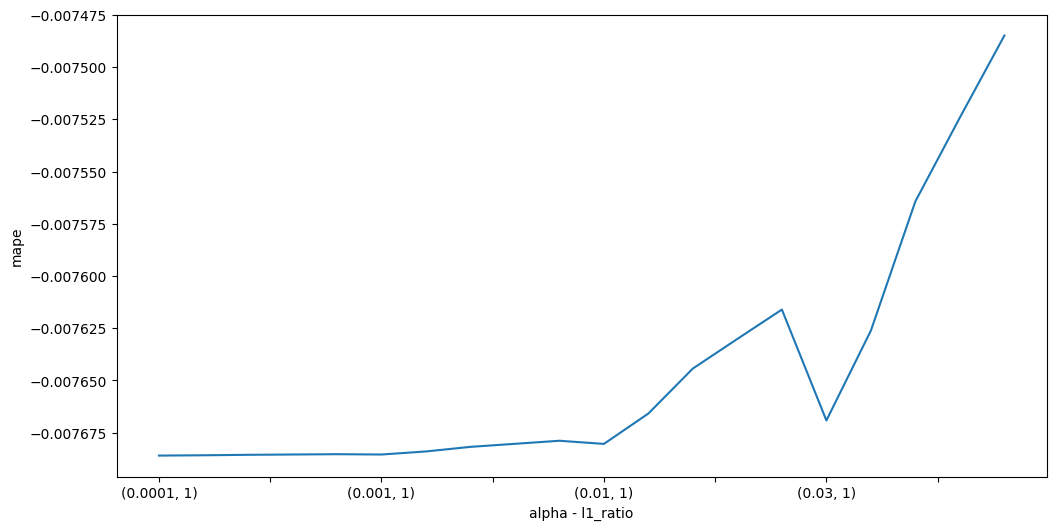

In [205]:
plt.rcParams["figure.figsize"] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index=idx)
p_cv_elastic.plot()
plt.xlabel("alpha - l1_ratio")
plt.ylabel("mape")

In [206]:
cv_elastic

[-0.007685963692288135,
 -0.007685816914080751,
 -0.0076855967783613175,
 -0.0076854500514361825,
 -0.007685303340498858,
 -0.007685455063301578,
 -0.0076839883641055245,
 -0.007681791320007921,
 -0.007680328446918061,
 -0.00767886728899813,
 -0.0076803785655052085,
 -0.007665819005824451,
 -0.007644289211222765,
 -0.007630115671288351,
 -0.007616073531808138,
 -0.007669152180804039,
 -0.0076261387816291114,
 -0.007564282032118295,
 -0.007524158031692198,
 -0.007484934006497068]

In [207]:
def run_elastic_net(sample_1):
    elastic = ElasticNet(alpha=1, l1_ratio=0.5)
    elastic.fit(sample_1.loc[:, x_col], sample_1.loc[:, y_col])
    coef = pd.Series(elastic.coef_, index=sample_1.loc[:, x_col].columns)
    print(
        "Elastic Net picked "
        + str(sum(coef != 0))
        + " variables and eliminated the other "
        + str(sum(coef == 0))
        + " variables"
    )
    return coef.sort_values()
    imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
    plt.rcParams["figure.figsize"] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Coefficients in the Elastic Net Model")
    plt.show()




Elastic Net picked 1 variables and eliminated the other 29 variables
Elastic Net picked 1 variables and eliminated the other 29 variables
Elastic Net picked 1 variables and eliminated the other 29 variables


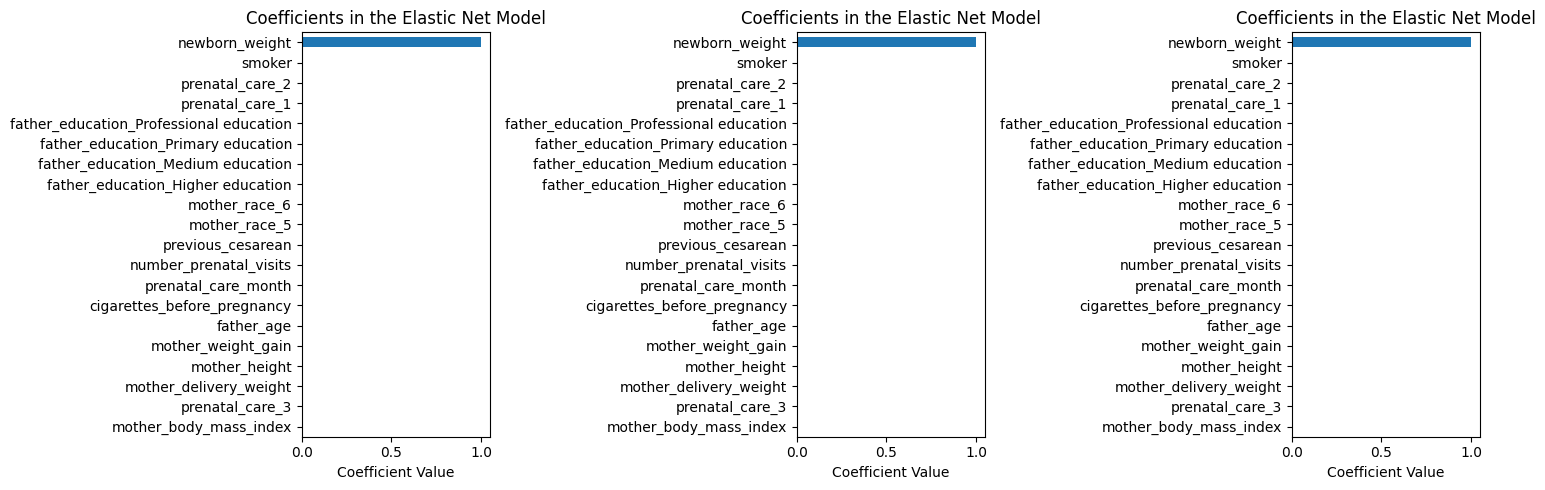

In [208]:
samples = [sample_1, sample_2, sample_3]
fix, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, sample in enumerate(samples):
    coef = run_elastic_net(sample)
    imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
    imp_coef.plot(kind="barh", ax=axes[i])
    axes[i].set_title("Coefficients in the Elastic Net Model")
    axes[i].set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

In [209]:
coef = run_elastic_net(sample_1)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

Elastic Net picked 1 variables and eliminated the other 29 variables


Elastic Net picked 1 variables and eliminated the other 29 variables
Elastic Net picked 1 variables and eliminated the other 29 variables
Elastic Net picked 1 variables and eliminated the other 29 variables


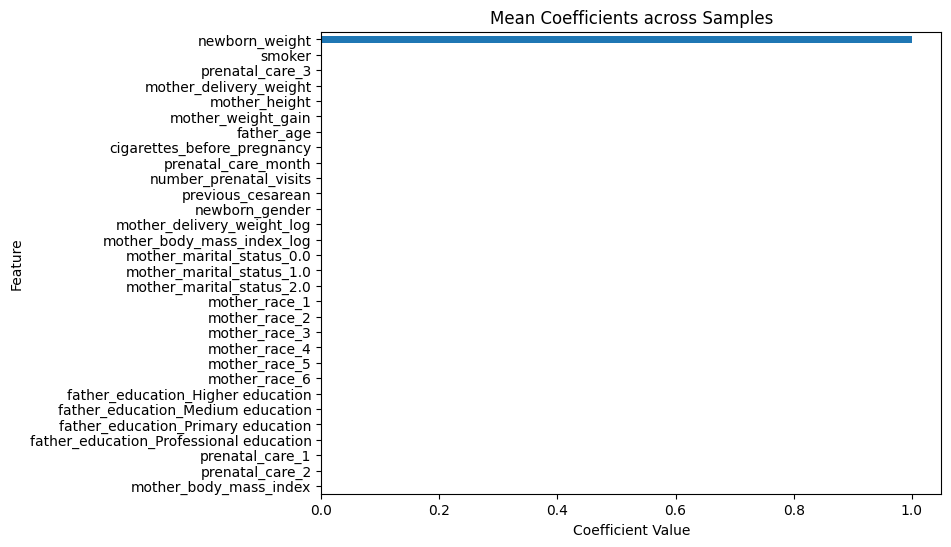

In [210]:
coefficients = pd.DataFrame()

# Run the Elastic Net and store the coefficients for each sample
for i, sample in enumerate(samples):
    coef = run_elastic_net(sample)
    coefficients['Sample ' + str(i+1)] = coef

# Calculate the mean of coefficients across the samples
mean_coefficients = coefficients.mean(axis=1)

# Plot the mean coefficients
plt.figure(figsize=(8, 6))
mean_coefficients.plot(kind="barh")
plt.title("Mean Coefficients across Samples")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [211]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(imp_coef),
    left_index=True,
    right_index=True,
    how="left",
)

In [212]:
corr = list()
for i in x_col:
    corr.append(stats.spearmanr(sample_1.loc[:, y_col].values, sample_1.loc[:, i].values)[0])
    

In [213]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(corr, index=x_col, columns=["corr"]),
    left_index=True,
    right_index=True,
)

In [214]:
pd.set_option("display.max_rows", 500)

In [215]:
general_ranking.sort_values(["mi_score","corr"], ascending=False)

,mi_score,sign_fscore,0,corr
newborn_weight,1.409951,0.000000e+00,0.999997,1.000000
mother_delivery_weight,0.035626,0.000000e+00,0.000000,0.210018
mother_delivery_weight_log,0.034466,0.000000e+00,NaN,0.210018
number_prenatal_visits,0.026552,0.000000e+00,0.000000,0.151811
mother_weight_gain,0.018225,0.000000e+00,0.000000,0.173592
mother_height,0.014862,0.000000e+00,0.000000,0.159227
mother_body_mass_index_log,0.012712,0.000000e+00,NaN,0.088134
mother_body_mass_index,0.010185,0.000000e+00,0.000000,0.088134
mother_race_1,0.009967,0.000000e+00,NaN,0.143148
mother_race_2,0.009407,0.000000e+00,NaN,-0.135876


In [216]:
import openpyxl


In [217]:
general_ranking.to_excel("data/output/feature_ranking.xlsx")
df.to_csv("data/output/train_fe.csv")
df_test.to_csv("data/output/test_fe.csv")

